In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

nltk.download('punkt')
nlp = spacy.blank('id')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_excel("dataset1000.xlsx")
df.head()

,label,komentar
0,positif,Oke pak boss!!
1,positif,PROBOWO is the WINNER of PEMILU 2014
2,positif,Hidup Pak Prabowo ..
3,positif,Ganteng bgt Pak :)
4,positif,ayo pak rujuk lagi sama bu titiek..hehhehe


In [3]:
df['label'].value_counts()

positif    1549
negatif     332
netral      120
Name: label, dtype: int64

In [4]:
komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[oke, pak, boss]"
1,positif,"[probowo, is, the, winner, of, pemilu]"
2,positif,"[hidup, pak, prabowo]"
3,positif,"[ganteng, bgt, pak]"
4,positif,"[ayo, pak, rujuk, lagi, sama, bu, titiek, hehh..."
...,...,...
1996,negatif,"[jangan, lupa, n, jangan, dugal, y, buat, yg, ..."
1997,negatif,"[no, we]"
1998,negatif,"[pasang, foto, biar, laku, ya, joko, xixixixi]"
1999,negatif,"[gw, pilih, no, prabowo, hata]"


In [5]:
df_tambahan = pd.read_excel("dataset_tambahan.xlsx")
df_tambahan

,label,komentar
0,negatif,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,negatif,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,negatif,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
3,negatif,"Dari sekian banyak thread yang aku baca, threa..."
4,negatif,"Contoh mereka yg gemar menyudutkan, teriak pal..."
...,...,...
2093,netral,bukan saya yang tidak-mau merit sat ini hubung...
2094,netral,Baru lihat kabar Teman nge gosip dan penuh inf...
2095,netral,Mengubah kebiasaan seseorang yg kurang baik it...
2096,netral,nah diam lebih bagus yaudah saya diam saja deh...


In [6]:
komentar = df_tambahan['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df_tambahan['komentar'] = komentar
df_tambahan

,label,komentar
0,negatif,"[soal, jln, jatibaru, polisi, tdk, bs, gertak,..."
1,negatif,"[sesama, cewe, lho, kayaknya, harusnya, bisa, ..."
2,negatif,"[jln, jatibaru, bagian, dari, wilayah, tn, aba..."
3,negatif,"[dari, sekian, banyak, thread, yang, aku, baca..."
4,negatif,"[contoh, mereka, yg, gemar, menyudutkan, teria..."
...,...,...
2093,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
2094,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
2095,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
2096,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [7]:
df = df[df.komentar.astype(bool)]
df_tambahan = df_tambahan[df_tambahan.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
X_train = X_train.append(df_tambahan.komentar)
y_train = y_train.append(df_tambahan.label)
y_train.value_counts()

negatif    1364
positif    1237
netral     1085
Name: label, dtype: int64

In [10]:
model = FastText.load('Model/XGB.bin')

In [11]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [12]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [13]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [14]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [15]:
weights = y_train_enc
weights = np.choose(weights, [0.9, 1.3, 1])

train=xgb.DMatrix(X_train_vector,label=y_train_enc, weight=weights)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

print("\nIni Weights\n", weights, "\n")
print("Ini y_train_encode\n", y_train_enc, "\n")


Ini Weights
 [1.3 1.3 0.9 ... 1.3 1.3 1.3] 

Ini y_train_encode
 [1 1 0 ... 1 1 1] 



In [16]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000

param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 4
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.37591	test-merror:0.36181
[1]	train-merror:0.32655	test-merror:0.33166
[2]	train-merror:0.30239	test-merror:0.32412
[3]	train-merror:0.29439	test-merror:0.32161
[4]	train-merror:0.27984	test-merror:0.32412
[5]	train-merror:0.27749	test-merror:0.30402
[6]	train-merror:0.26828	test-merror:0.28392
[7]	train-merror:0.26423	test-merror:0.29146
[8]	train-merror:0.25705	test-merror:0.29648
[9]	train-merror:0.25713	test-merror:0.29397
[10]	train-merror:0.25047	test-merror:0.29648
[11]	train-merror:0.24900	test-merror:0.29146
[12]	train-merror:0.24593	test-merror:0.27889
[13]	train-merror:0.24332	test-merror:0.28392
[14]	train-merror:0.24580	test-merror:0.28392
[15]	train-merror:0.24423	test-merror:0.27889
[16]	train-merror:0.24010	test-merror:0.29146
[17]	train-merror:0.24023	test-merror:0.29648
[18]	train-merror:0.24041	test-merror:0.28895
[19]	train-merror:0.23721	test-merror:0.27638
[20]	train-merror:0.23468	test-merror:0.27889
[21]	train-merror:0.23447	test-merror:0.2788

[177]	train-merror:0.18209	test-merror:0.26633
[178]	train-merror:0.18180	test-merror:0.26633
[179]	train-merror:0.18095	test-merror:0.26633
[180]	train-merror:0.18152	test-merror:0.26633
[181]	train-merror:0.18185	test-merror:0.26633
[182]	train-merror:0.18129	test-merror:0.26633
[183]	train-merror:0.18015	test-merror:0.26633
[184]	train-merror:0.18030	test-merror:0.26382
[185]	train-merror:0.17935	test-merror:0.26382
[186]	train-merror:0.18028	test-merror:0.26382
[187]	train-merror:0.18043	test-merror:0.26131
[188]	train-merror:0.17878	test-merror:0.26131
[189]	train-merror:0.17858	test-merror:0.25879
[190]	train-merror:0.17741	test-merror:0.25879
[191]	train-merror:0.17757	test-merror:0.25879
[192]	train-merror:0.17803	test-merror:0.26131
[193]	train-merror:0.17628	test-merror:0.26633
[194]	train-merror:0.17638	test-merror:0.26382
[195]	train-merror:0.17494	test-merror:0.26382
[196]	train-merror:0.17749	test-merror:0.26382
[197]	train-merror:0.17644	test-merror:0.26382
[198]	train-m

[352]	train-merror:0.13863	test-merror:0.25879
[353]	train-merror:0.13840	test-merror:0.26131
[354]	train-merror:0.13767	test-merror:0.25879
[355]	train-merror:0.13698	test-merror:0.26131
[356]	train-merror:0.13698	test-merror:0.26131
[357]	train-merror:0.13595	test-merror:0.26382
[358]	train-merror:0.13607	test-merror:0.26382
[359]	train-merror:0.13589	test-merror:0.26131
[360]	train-merror:0.13520	test-merror:0.26382
[361]	train-merror:0.13597	test-merror:0.26382
[362]	train-merror:0.13558	test-merror:0.26131
[363]	train-merror:0.13514	test-merror:0.26382
[364]	train-merror:0.13468	test-merror:0.26382
[365]	train-merror:0.13538	test-merror:0.26382
[366]	train-merror:0.13502	test-merror:0.26382
[367]	train-merror:0.13502	test-merror:0.26382
[368]	train-merror:0.13478	test-merror:0.26382
[369]	train-merror:0.13445	test-merror:0.25879
[370]	train-merror:0.13445	test-merror:0.26131
[371]	train-merror:0.13525	test-merror:0.26131
[372]	train-merror:0.13499	test-merror:0.25879
[373]	train-m

[527]	train-merror:0.10903	test-merror:0.25377
[528]	train-merror:0.10880	test-merror:0.25377
[529]	train-merror:0.10880	test-merror:0.25377
[530]	train-merror:0.10913	test-merror:0.25126
[531]	train-merror:0.10887	test-merror:0.25628
[532]	train-merror:0.10854	test-merror:0.25377
[533]	train-merror:0.10880	test-merror:0.25628
[534]	train-merror:0.10864	test-merror:0.25126
[535]	train-merror:0.10864	test-merror:0.25377
[536]	train-merror:0.10782	test-merror:0.25628
[537]	train-merror:0.10769	test-merror:0.25628
[538]	train-merror:0.10733	test-merror:0.25628
[539]	train-merror:0.10653	test-merror:0.25628
[540]	train-merror:0.10583	test-merror:0.25628
[541]	train-merror:0.10542	test-merror:0.25628
[542]	train-merror:0.10549	test-merror:0.25628
[543]	train-merror:0.10622	test-merror:0.25628
[544]	train-merror:0.10575	test-merror:0.25628
[545]	train-merror:0.10645	test-merror:0.25628
[546]	train-merror:0.10601	test-merror:0.25628
[547]	train-merror:0.10562	test-merror:0.25377
[548]	train-m

[702]	train-merror:0.08449	test-merror:0.25879
[703]	train-merror:0.08389	test-merror:0.25879
[704]	train-merror:0.08356	test-merror:0.25879
[705]	train-merror:0.08400	test-merror:0.25879
[706]	train-merror:0.08343	test-merror:0.25879
[707]	train-merror:0.08297	test-merror:0.25879
[708]	train-merror:0.08356	test-merror:0.25879
[709]	train-merror:0.08366	test-merror:0.25879
[710]	train-merror:0.08299	test-merror:0.25879
[711]	train-merror:0.08276	test-merror:0.25879
[712]	train-merror:0.08242	test-merror:0.25879
[713]	train-merror:0.08250	test-merror:0.25628
[714]	train-merror:0.08286	test-merror:0.25879
[715]	train-merror:0.08227	test-merror:0.25879
[716]	train-merror:0.08157	test-merror:0.25879
[717]	train-merror:0.08111	test-merror:0.25879
[718]	train-merror:0.08167	test-merror:0.25879
[719]	train-merror:0.08121	test-merror:0.25879
[720]	train-merror:0.08144	test-merror:0.25879
[721]	train-merror:0.08144	test-merror:0.25879
[722]	train-merror:0.08118	test-merror:0.25879
[723]	train-m

[877]	train-merror:0.06338	test-merror:0.25628
[878]	train-merror:0.06369	test-merror:0.25628
[879]	train-merror:0.06369	test-merror:0.25628
[880]	train-merror:0.06346	test-merror:0.25628
[881]	train-merror:0.06405	test-merror:0.25628
[882]	train-merror:0.06428	test-merror:0.25628
[883]	train-merror:0.06428	test-merror:0.25628
[884]	train-merror:0.06405	test-merror:0.25628
[885]	train-merror:0.06356	test-merror:0.25628
[886]	train-merror:0.06356	test-merror:0.25628
[887]	train-merror:0.06284	test-merror:0.25628
[888]	train-merror:0.06307	test-merror:0.25628
[889]	train-merror:0.06333	test-merror:0.25879
[890]	train-merror:0.06346	test-merror:0.25879
[891]	train-merror:0.06299	test-merror:0.25879
[892]	train-merror:0.06346	test-merror:0.25879
[893]	train-merror:0.06276	test-merror:0.25879
[894]	train-merror:0.06250	test-merror:0.25879
[895]	train-merror:0.06227	test-merror:0.25879
[896]	train-merror:0.06227	test-merror:0.25879
[897]	train-merror:0.06230	test-merror:0.25879
[898]	train-m

In [17]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [18]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [19]:
test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.7437185929648241 

Train Score
 0.9441128594682583 

CONFUSSION MATRIX
 [[ 22   3  41]
 [ 10   5   7]
 [ 26  15 269]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.38      0.33      0.35        66
      netral       0.22      0.23      0.22        22
     positif       0.85      0.87      0.86       310

    accuracy                           0.74       398
   macro avg       0.48      0.48      0.48       398
weighted avg       0.74      0.74      0.74       398
 



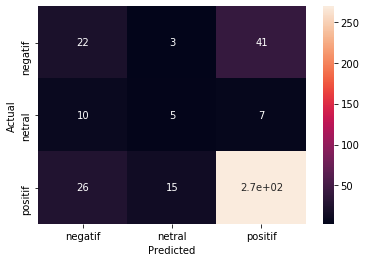

In [20]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [21]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])